In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append(r'modules')
from pathlib import Path

import particleanalyzer as pa
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.external import tifffile
from skimage.util.dtype import dtype_range
from skimage import exposure
from skimage.util import invert
from skimage import img_as_ubyte
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
import cv2 as cv
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

In [3]:
bfrpath = r'c:\Users\m1srh\Documents\GitHub\BioFormatsRead'
#bfrpath = r'd:\Users\m1srh\Documents\Github\BioFormatsRead'
bfpackage = r'c:\Users\m1srh\Documents\Software\Bioformats\5.9.2\bioformats_package.jar'
#bfpackage = r'd:\Users\m1srh\Documents\Github\BioFormatsRead\bfpackage\5.9.2\bioformats_package.jar'

filename = r'c:\Users\m1srh\OneDrive - Carl Zeiss AG\Projects\Apeer\ZenCore_Workflows\ParticleAnalysis\Filtertest1_POL.czi'
#filename = r'd:\Users\m1srh\OneDrive - Carl Zeiss AG\Projects\Apeer\ZenCore_Workflows\ParticleAnalysis\Filtertest1_POL.czi'

In [4]:
imgarray, omexml, metainfo = pa.readpaimage(filename, bfrpath=bfrpath,
                                                      bfpackage=bfpackage,
                                                      use_BF=True)

Multi-Resolution API not enabled yet.
Retrieving Image Dimensions ...
T:  1 Z:  1 C:  1 X:  11286 Y:  11313
Using czifile.py to get CZI Shape info.
Using BioFormats to get MetaInformation.
Problem reading Detector Model.
Reading MultiRes File.


OME NameSpace used   :  http://www.openmicroscopy.org/Schemas/OME/2016-06
BF Version used      :  c:\Users\m1srh\Documents\Software\Bioformats\5.9.2\bioformats_package.jar
-------------------------------------------------------------
Image Directory      :  c:\Users\m1srh\OneDrive - Carl Zeiss AG\Projects\Apeer\ZenCore_Workflows\ParticleAnalysis
Image Filename       :  Filtertest1_POL.czi
MutiResolution       :  True
Series Dimensions    :  [(11286, 11313), (3762, 3771), (1254, 1257), (418, 419)]
Images Dim Sizes [0] :  [4, 1, 1, 1, 11313, 11286]
Dimension Order BF   :  XYCZT
Dimension Order CZI  :  TCZYX0
Shape CZI            :  (1, 1, 1, 11313, 11286, 1)
Total Series Number  :  4
Image Dimensions     :  4 1 1 1 11313 11286
Scaling XYZ [micron

In [5]:
cut = True

x1=2000
x2=4000
y1=2000
y2=4000
    
array = np.squeeze(imgarray)

if cut:
    array = array[x1:x2, y1:y2]
    print('Cutout Image Size :  ', array.shape)

#array = img_as_ubyte(array)
minpix = array.min()
maxpix = array.max()

Cutout Image Size :   (2000, 2000)


In [6]:
# Optional - Subtract minimum value from image before processing
#array = array - array.min() + 1

# Optional - Appy Median filter to image
kernelsize = 3
#array = cv.medianBlur(array, kernelsize)

Index for this Value      :  [208]
Most frequent Pixel Value :  [202.]
Luminosity [%]            :  [79.]
Relative Treshold Value   :  0.65
abs. Treshold Value       :  [131.]


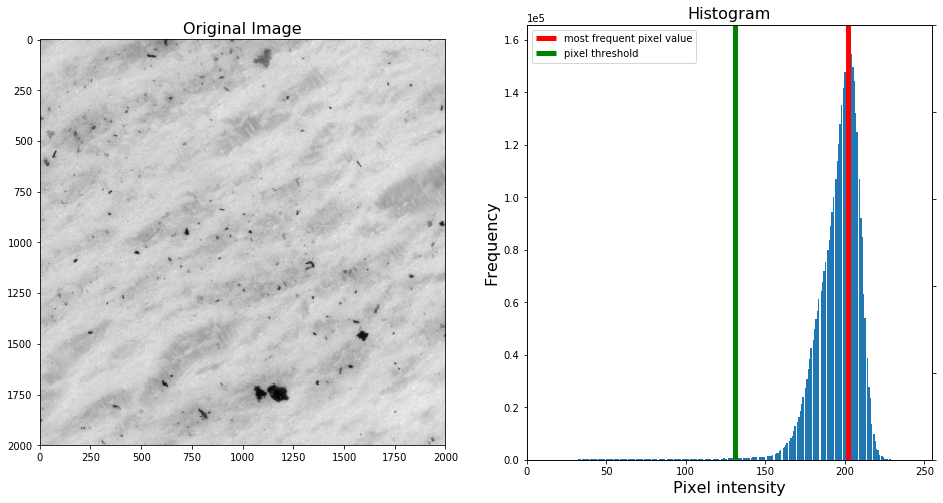

In [7]:
# define number of bins for histogram
bins = 256
#bins = 'auto'

# define relative threshold - default = 65%
th_rel = 0.65

# create figure
fig, ax = plt.subplots(1,2, figsize=(16, 8))

# display original image subset
ax[0].imshow(array, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Original Image', fontsize=16)
xmin, xmax = dtype_range[array.dtype.type]

# calculate histogram and return values
values, bins, bars = ax[1].hist(array.ravel(), bins=bins)

# find the index for the histogram peak
v = np.where(values == values.max())

# get the most frequent pixel value
most_frequent_value = pa.findhistogrammpeak(values, bins)
luminosity = np.round(most_frequent_value / 255 * 100, 0)

# calculate threshold pixel value from relative threshold
threshold = np.round(most_frequent_value * th_rel, 0)

# customize plots
ax[1].set_title('Histogram', fontsize=16)
ax[1].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax[1].set_xlabel('Pixel intensity', fontsize=16)
ax[1].set_ylabel('Frequency', fontsize=16)
ax[1].set_xlim(xmin, xmax)

# display distribution
axh = ax[1].twinx()
axh.vlines(most_frequent_value, 0, 1, colors='r', linestyles='solid', lw=5, label='most frequent pixel value')
axh.vlines(threshold, 0, 1, colors='g', linestyles='solid', lw=5, label='pixel threshold')
axh.set_ylim(0, 1)
axh.legend(loc='upper left')

# turn off tick labels
axh.set_yticklabels([])

print('Index for this Value      : ', v[0])
print('Most frequent Pixel Value : ', most_frequent_value)
print('Luminosity [%]            : ', luminosity)
print('Relative Treshold Value   : ', th_rel)
print('abs. Treshold Value       : ', threshold)

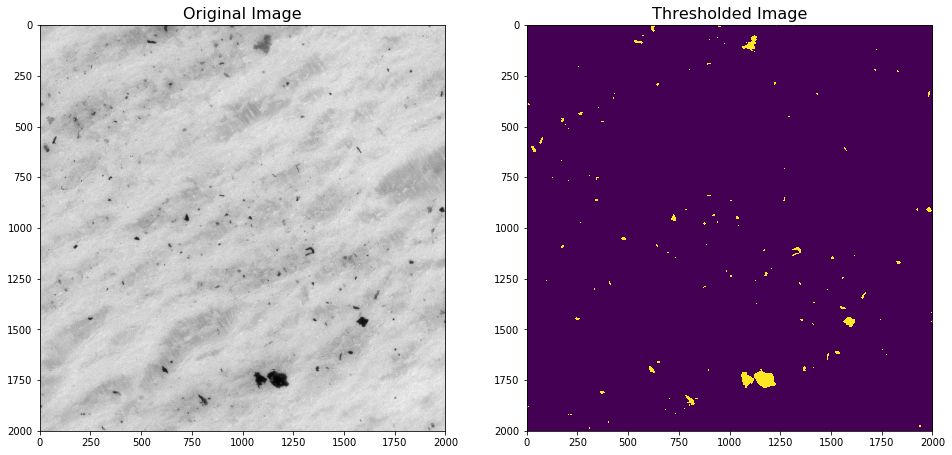

In [8]:
# apply the threshold to the image and invert the result to get the dark particles
th_img = pa.autoThresholding(array, method='value_based', value=threshold)
th_img = invert(th_img)

# dosplay the result
fig, ax = plt.subplots(1,2, figsize=(16, 8))

ax[0].imshow(array, cmap=plt.cm.gray, interpolation='nearest')
ax[1].imshow(th_img)

ax[0].set_title('Original Image', fontsize=16)
ax[1].set_title('Thresholded Image', fontsize=16)
plt.show()

In [9]:
# remover particles from the edge
th_img = clear_border(th_img)

# label the particles
img_label, num_label = label(th_img, background=0, return_num=True, connectivity=2)

print('Initial Number of Particles       : ', num_label)

# remove small objects
min_particle_area_micron = 4
min_particle_size_pixel = np.int(np.round(min_particle_area_micron / (metainfo['XScale']**2), 0))
print('Minimum Particle Size [micron**2] :  {:.2f}'.format(min_particle_area_micron))
print('Minimum Particle Size Pixel       :  {:.2f}'.format(min_particle_size_pixel))

img_label_srm = remove_small_objects(img_label, min_particle_size_pixel, in_place=False)

Initial Number of Particles       :  146
Minimum Particle Size [micron**2] :  4.00
Minimum Particle Size Pixel       :  13.00


In [10]:
particlesizeclasses = {'A': [0, 5],
                       'B': [5, 15],
                       'C': [15, 25],
                       'D': [25, 50],
                       'E': [50, 1000],
                       'F': [100, 150],
                       'G': [150, 200],
                       'H': [200, 400],
                       'I': [400, 600],
                       'J': [600, 1000],
                       'K': [1000, 1500],
                       'L': [1500, 2000],
                       'M': [2000, 3000],
                       'N': [3000, np.inf]
                   }

particlesizecolors = {'A': 0,
                      'B': 1,
                      'C': 2,
                      'D': 3,
                      'E': 4,
                      'F': 5,
                      'G': 6,
                      'H': 7,
                      'I': 8,
                      'J': 9,
                      'K': 10,
                      'L': 11,
                      'M': 12,
                      'N': 13
                   }
NUM_COLORS = len(list(particlesizeclasses.keys()))

# create distinct color for every class for later visualization
jet= plt.get_cmap('jet')
COLORS_RECT = jet(np.linspace(0, 2, NUM_COLORS))

Skipped Particles :  41


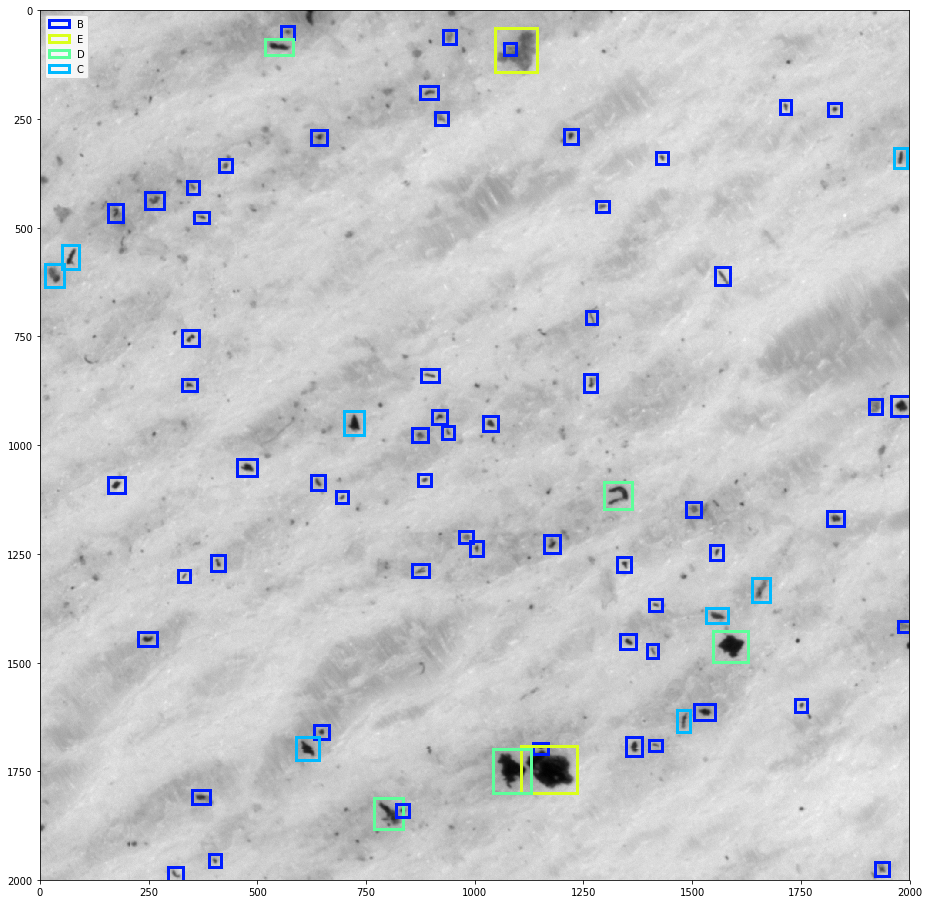

In [18]:
# create colored overlays
#image_label_overlay = label2rgb(img_label_srm, image=array, bg_label=0)

# grayish labeled objects 
#image_label_overlay = img_label_srm

# show original image only and not labels
image_label_overlay = array

# display the labelled image
fig, ax_label = plt.subplots(figsize=(16, 16))
ax_label.imshow(image_label_overlay, cmap=plt.cm.gray, interpolation='nearest')

# offset to make bounding boxes a "bit bigger"
offset = 10
drawrect = True

# create emtpy dictionary for all the particles and lust for particle classes
objects = {}
skipped = 0

# loop over all detected objects
for region in regionprops(img_label_srm, intensity_image=array):
    
    # create dictionary for the individual particle properties
    properties = {}
    
    # calculate FeretMax
    feretmax = region.major_axis_length * metainfo['XScale']
    feretmin = region.minor_axis_length * metainfo['XScale']
    
    # skip particles where the FeretMax is smaller than ...
    #if feretmax < 5:
    #    #print ('Skipped particle because it was too small.')
    #    skipped = skipped + 1
    #    continue
    
    # calculate perimeter, area and fiberlength of object
    perimeter = region.perimeter * metainfo['XScale']
    area = region.area * metainfo['XScale'] ** 2
    
    fiberlength = 0.25 * (area + np.sqrt(perimeter**2 - 16*area))
    # check if it was possible to calculate the fiberlength
    if np.isnan(fiberlength):
        fiberlength = 0.0
     
    # classify objects according the th given size class definitions
    properties['Class'] = pa.classify(feretmax, particlesizeclasses)
    #particleclasses.append(properties['Class'])
    
    # assign color deopending on the size class
    properties['ClassColor'] = COLORS_RECT[particlesizecolors[properties['Class']], :]
    
    # fill the dictionary
    properties['Perimeter'] = perimeter
    properties['Area'] = area
    properties['FiberLength'] = fiberlength
    properties['FeretMax'] = feretmax
    properties['FeretMin'] = feretmin
    # convert boolean array to 0-1 array
    properties['LabelImage'] = region.image*1
    
    # calculate maximum inscribed circle diameter
    mic_radius = float(pa.getmaxinscribedcircle(properties['LabelImage'])[0])
    properties['maxMIC'] = mic_radius * 2 * metainfo['XScale']
    
    # calculate ratio length - width
    if feretmin > 0:
        # calculate the ratio from feretmax and feretmin
        properties['FeretRatio'] = region.major_axis_length / region.minor_axis_length
        
        # check if this is a fiber using a special criterion
        if properties['maxMIC'] <=50  and (properties['FiberLength']/properties['maxMIC']) > 20:
            properties['IsFiber'] = True
        else:
            properties['IsFiber'] = False
    
    elif feretmin == 0:
        # on case feretmin = 0 (should never be) set values
        properties['FeretRatio'] = np.NaN
        print('FeretRatio set to NaN')
        properties['IsFiber'] = 'ND'
    
    # get the intensity image
    ri = region.intensity_image 
    ri = ri.astype('float')
    ri[ri==0] = np.NaN
    properties['IntensityImage'] = ri

    # store parameters of current object in dictionary for all objects
    objects[region.label] = properties
    
    if drawrect and objects[region.label]['FeretMax'] >= 5:
        
        # draw rectangle around segmented particles and make the bounding rectangle bigger
        minr, minc, maxr, maxc = region.bbox
        minr = minr - offset
        maxr = maxr + offset
        minc = minc - offset
        maxc = maxc + offset
        
        # add rectangle and legend, but only if "this" legend was not already added
        
        if properties['IsFiber']:
            ls = 'dotted'
        if not properties['IsFiber']:
            ls = 'solid'
        if properties['IsFiber'] == 'ND':
            ls = 'dashed'
        
        # draw rectangles depending on class
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False,
                                  edgecolor=properties['ClassColor'],
                                  linewidth=3,
                                  linestyle=ls,
                                  label=str(properties['Class']) if str(properties['Class']) not in plt.gca().get_legend_handles_labels()[1] else '')

        ax_label.add_patch(rect)
        ax_label.legend(loc='upper left')
        
    # check for small particles and delete entry from dict
    if objects[region.label]['FeretMax'] < 5:
        objects.pop(region.label, None)
        skipped = skipped + 1

print('Skipped Particles : ', skipped)
        
#plt.show()

In [19]:
# count number of particles and fibers
num_all_objects = len(objects)
num_particles = 0
num_fibers = 0
num_ND = 0

for obj in objects.keys():
    
    fiber = objects[obj]['IsFiber']
    if fiber == True:
        num_fibers = num_fibers + 1
    if fiber == False:
        num_particles = num_particles + 1
    if fiber == 'ND':
        num_ND = num_ND + 1

print('All Objects :', num_all_objects)
print('Particles   :', num_particles)
print('Fibers      :', num_fibers)
print('Not Defined :', num_ND)

All Objects : 74
Particles   : 74
Fibers      : 0
Not Defined : 0


In [20]:
# calculate number of needed columns and rows for particle grid plot
nc = np.int(np.round(np.sqrt(num_particles)))
nr = nc + 1
nrr = np.int(np.round(nr*nc/10, 0) + 2)
maxcols = 15
print(nrr, maxcols)

# create list with all particle IDs
ids = list(objects)

11 15


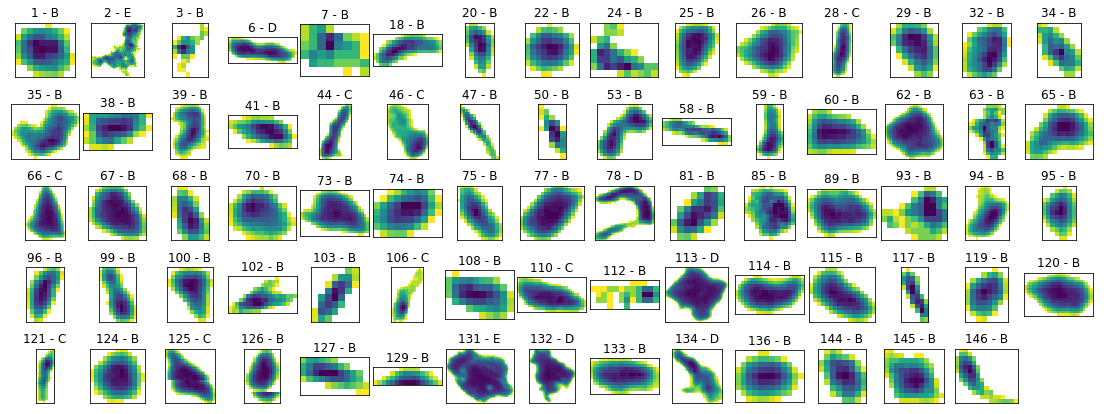

In [21]:
# create subplots
fig, axp = plt.subplots(nrows=nrr, ncols=maxcols, figsize=(16, 16), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.5, wspace=0.05)

count = 0

for axpp, pid in zip(axp.flat, ids):
    
    count = count + 1
    
    # extract the image of the current particle
    p = objects[pid]['IntensityImage']
    c = objects[pid]['Class']
    
    if objects[pid]['IsFiber']:
        axpp.imshow(p, cmap=plt.cm.hot, interpolation='nearest')
    
    if not objects[pid]['IsFiber']:
        axpp.imshow(p, cmap='viridis', interpolation='nearest')
    
    axpp.set_title(str(pid) + ' - ' + c)
    axpp.set_facecolor('white')
    #axpp.axis('off')

# remove empty axes
for ad in range(num_particles, nrr*maxcols):
#for ad in range(num_particles, nr*nc):
    fig.delaxes(axp.flatten()[ad])   

#plt.axis()    
#plt.show()

Class                :  E
Area         [micron]:  754.23
FeretMax     [micron]:  50.04
FeretMin     [micron]:  27.13
FeretRatio           :  1.84
FiberLength  [micron]:  229.17
IsFiber              :  False
Perimeter    [micron]:  196.10
Diameter MIC [micron]:  14.20


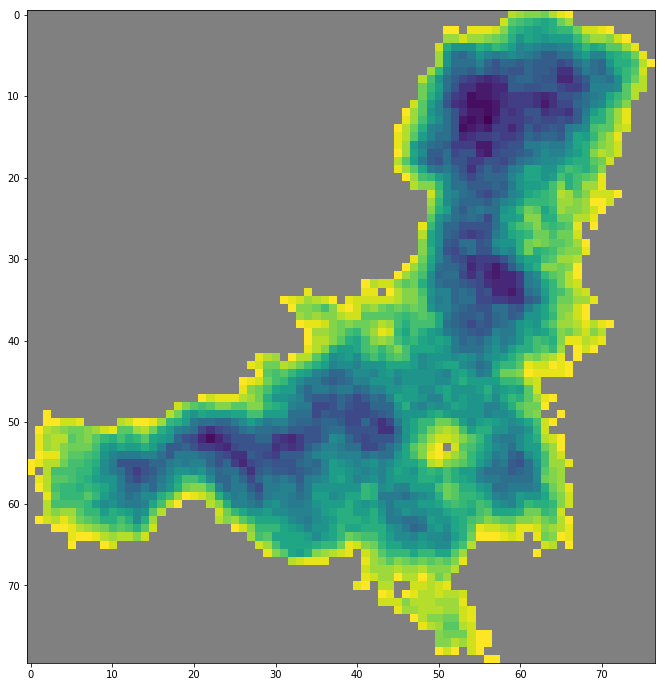

In [22]:
id2show = 2
obj = objects[id2show]

print('Class                : ', obj['Class'])
print('Area         [micron]:  {:.2f}'.format(obj['Area']))
print('FeretMax     [micron]:  {:.2f}'.format(obj['FeretMax']))
print('FeretMin     [micron]:  {:.2f}'.format(obj['FeretMin']))
print('FeretRatio           :  {:.2f}'.format(obj['FeretRatio']))
print('FiberLength  [micron]:  {:.2f}'.format(obj['FiberLength']))
print('IsFiber              : ', obj['IsFiber'])
print('Perimeter    [micron]:  {:.2f}'.format(obj['Perimeter']))
print('Diameter MIC [micron]:  {:.2f}'.format(obj['maxMIC']))

fig, axobj = plt.subplots(figsize=(12, 12))

if obj['IsFiber']:
    axobj.imshow(obj['IntensityImage'], cmap=plt.cm.hot)
if not obj['IsFiber']:
    axobj.imshow(obj['IntensityImage'], cmap='viridis')

axobj.set_facecolor('grey')    

#plt.show()

In [ ]:
# create list for a specific parameter
parameters = []
paramstring = 'FeretMax'

for k in objects.keys():
    parameters.append(objects[k][paramstring])
    
param_array = np.asarray(parameters)
param_array.shape

In [ ]:
# create figure
fig, ax_area = plt.subplots(1,1, figsize=(12, 8))

# Display histogram and return values
p_values, p_bins, p_bars = ax_area.hist(param_array.ravel(),
                                        bins='auto',
                                        #bins=256,
                                        align='mid',
                                        rwidth=0.5,
                                        log=False,
                                        color='red',
                                        label=paramstring)

# find the index for the highest values
v_param = np.where(p_values == p_values.max())

# get the most frequent pixel value
p_most_frequent_value = pa.findhistogrammpeak(p_values, p_bins)

p_mean = np.round(param_array.mean(), 1)
p_median = np.round(np.median(param_array), 1)
p_std = np.round(param_array.std(), 1)

#ax_area.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax_area.set_xlabel(paramstring, fontsize=16)
ax_area.set_ylabel('Frequency', fontsize=16)
ax_area.set_xlim(0, param_array.max())
ax_area.grid(True)
ax_area.legend(loc='center right')

# plot vertical lines for mean an median values
ax_area1 = ax_area.twinx()
ax_area1.vlines(p_mean, 0, 1, colors='b', linestyles='dashed', lw=5, label='Mean')
ax_area1.vlines(p_median, 0, 1, colors='g', linestyles='dashed', lw=5, label='Median')
ax_area1.set_ylim(0, 1)
ax_area1.legend(loc='upper right')
# Turn off tick labels
ax_area1.set_yticklabels([])

print('Most frequent Value       : ', p_most_frequent_value)
print('Index for this Value      : ', v_param[0])
print('Minimum Particle Size     :  {:.2f}'.format(param_array.min()))
print('Maximum Particle Size     :  {:.2f}'.format(param_array.max()))
print('Mean Particle Size        :  {:.2f}'.format(p_mean))
print('Median Particle Size      :  {:.2f}'.format(p_median))
print('Std. Dev. Particle Size   :  {:.2f}'.format(p_std))

# show plot
#plt.show()

In [ ]:
# create pandas dataframe with all particles
df = pd.DataFrame(objects)
df = df.transpose().reset_index()
df = df.drop(['ClassColor', 'LabelImage', 'IntensityImage'], axis=1)
df.rename(index=str, columns={"index": "ParticleID"}, inplace=True)

# define new order of columns
columnsTitles=['ParticleID',
               'Class',
               'Area',
               'IsFiber',
               'FiberLength',
               'FeretMin',
               'FeretMax',
               'FeretRatio',
               'maxMIC',
               'Perimeter']

# do the reindexing and show the dataframe
df = df.reindex(columns=columnsTitles)
df[:10]

In [ ]:
# write data to excel sheet

# get filename without extension
basename_woext = os.path.basename(filename).split('.')[0]
basepath = os.path.dirname(filename)

# define name for excelsheet
excelfile = os.path.join(basepath, basename_woext + '_PA_Results.xlsx')

# check for an already existing file and skip saving it in case it exists already
resultfile = Path(excelfile)
if not resultfile.is_file():
    writer = pd.ExcelWriter(excelfile)
    df.to_excel(writer,'Particle Analysis Results')
    writer.save()
    print('Saved results to :', excelfile)
    
elif resultfile.is_file():
    print('File already exits. Did not write anything.')

cd c:\Users\m1srh\OneDrive - Carl Zeiss AG\IPython_Notebooks\ZEN_Wellplate_Analysis_Pandas\

jupyter nbconvert ZEN_Wellplate_Analysis_Pandas_Translocation_Tutorial.ipynb --to slides --post serve

jupyter nbconvert ZEN_Wellplate_Analysis_Pandas_Translocation_Tutorial.ipynb --to slides --post serve --SlidesExporter.reveal_theme=serif --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_transition=none